v5

목표  
CNN 모델만들어 이미지 분류  


---
CNN 이론 이해  
텐서플로로 구현하여 CNN의 동작과정을 이해하고자 한다  


---
데이터셋  

채소모음 https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition  
colab과 kaggle 연동하여 업로드  



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import ResNet101V2
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
#colab과 Kaggle 연동 및 다운로드
!pip install kaggle  
from google.colab import files  
files.upload()  
!mkdir -p ~/.kaggle  
!cp kaggle.json ~/.kaggle/  # Kaggle.json (Kaggle API Token) upload
!chmod 600 ~/.kaggle/kaggle.json  
!kaggle datasets list -s english-french   
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition # 참고할 Kaggle API
!unzip englishfrench-translations.zip  
!ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
ref                                               title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
dhruvildave/en-fr-translation-dataset             English-French Translation Dataset                  3GB  2021-02-09 19:27:52           1294         35  1.0              
devicharith/language-translation-englishfrench    Language Translation (English-French)               4MB  2020-04-08 11:35:32           1145         31  0.8235294        
digvijayyadav/frenchenglish                       English to French translations                      6MB  2020-07-27 16:22:20            305         17  1.0              
jannesklaas/frenchenglish-bilingual-pairs         French-English Bilingual Pairs                      6MB 

In [ ]:
# zip 풀기
%cd "/content/"
!unzip -qq "/content/fruit-and-vegetable-image-recognition.zip"

/content


In [ ]:
#test
# train = ImageDataGenerator(horizontal_flip=True, rescale=1/255.)
# test = ImageDataGenerator(rescale=1/255.)
# #.flow_from_directory는 하위 디렉토리 이름을 레이블이라고 간주!! -> Numpy Array Iterator 생성
# train_flow_gen = train.flow_from_directory(directory='/content/train',
#                                               target_size=(244, 244),  # 사용할 CNN 모델 입력 사이즈에 맞게 resize
#                                               class_mode='categorical',#멀티-레이블 클래스로, 원-핫 인코딩된 형태
#                                               batch_size=32,
#                                               shuffle=True)
# test_flow_gen = test.flow_from_directory(directory='/content/test',
#                                             target_size=(244, 244),  # 사용할 CNN 모델 입력 사이즈에 맞게 resize
#                                             class_mode='categorical',
#                                             batch_size=32,
#                                             shuffle=False)

# 데이터셋 데이터 전처리

Image DataGenerator  
이미지를 학습시킬 때 학습데이터의 양이 적을 경우

학습데이터를 조금씩 변형시켜서 학습데이터의 양을 늘리는 방식중에 하나  

감자 이미지를 1 픽셀 옆으로 민다고 고구마 이미지가 되진 않는다.  
회전, 확대, 이동, 반전 등의 효과를 적용해도 감자는 여전히 감자이다.  
하지만 픽셀 데이터 상으로는 완전히 다른 데이터이므로 이 점을 이용해 데이터 증식과 위치이동이나 회전에 대한 학습도 진행할 수 있다

In [ ]:
train_data = ImageDataGenerator(rescale=1/255.,
                                  horizontal_flip=True, # 랜덤 가로 뒤짚기
                                  shear_range=True, # 랜덤으로 이미지 밀어 찌그러트리기
                                  rotation_range=30, #  -30 ~ 30도 범위 랜덤 회전
                                  zoom_range=0.3, # 랜덤 줌 범위 30%
                                  width_shift_range=0.3, # 30% 범위로 좌우 이동
                                  height_shift_range=0.3 # 30% 범위로 상하 이동
                                )

In [ ]:
train_images = train_data.flow_from_directory('/content/train',
                                                target_size=(64,64),
                                                batch_size=32,
                                                class_mode='categorical')

Found 3115 images belonging to 36 classes.


In [ ]:
val_data = ImageDataGenerator(rescale=1/255.)

val_images = val_data.flow_from_directory('/content/validation',
                                                target_size=(64,64),
                                                batch_size=32,
                                                class_mode='categorical')

Found 351 images belonging to 36 classes.


In [ ]:
test_data = ImageDataGenerator(rescale=1/255.)

test_images = test_data.flow_from_directory('/content/test',
                                           target_size=(64,64),
                                           batch_size=32,
                                           class_mode='categorical')

Found 359 images belonging to 36 classes.


# 모델 구성

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32,activation='relu',kernel_size=(3,3),input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,activation='relu',kernel_size=(3,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,activation='relu',kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(filters=256,activation='relu',kernel_size=(3,3)))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=64,activation='relu'))
#model.add(Dense(units=128,activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.3))
model.add(Dense(units=36,activation='softmax'))

컴파일

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 128)      5

In [ ]:
resnet_v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(64,64,3))

for layer in resnet_v2.layers:
    layer.trainable = False
    
base_model = resnet_v2.output
base_model = Flatten()(base_model)
base_model = Dense(512,activation='relu')(base_model)
base_model = Dense(36,activation='softmax')(base_model)

model = Model(inputs=resnet_v2.input,outputs=base_model)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')
model.summary();

171317808/171317808 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                           

# 훈련
 


In [ ]:
history = model.fit(train_images,
              epochs=100,
              batch_size=32,
              validation_data=val_images)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/100
 2/98 [..............................] - ETA: 2:04 - loss: 5.9730 - accuracy: 0.0625     

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


98/98 [==============================] - 152s 1s/step - loss: 3.4580 - accuracy: 0.2128 - val_loss: 2.0262 - val_accuracy: 0.4701
Epoch 2/100
98/98 [==============================] - 141s 1s/step - loss: 2.6244 - accuracy: 0.3217 - val_loss: 1.7179 - val_accuracy: 0.5413
Epoch 3/100
98/98 [==============================] - 139s 1s/step - loss: 2.4411 - accuracy: 0.3708 - val_loss: 1.4486 - val_accuracy: 0.6296
Epoch 4/100
98/98 [==============================] - 140s 1s/step - loss: 2.3891 - accuracy: 0.3936 - val_loss: 1.3753 - val_accuracy: 0.6211
Epoch 5/100
98/98 [==============================] - 140s 1s/step - loss: 2.2459 - accuracy: 0.4090 - val_loss: 1.4663 - val_accuracy: 0.6239
Epoch 6/100
98/98 [==============================] - 140s 1s/step - loss: 2.2013 - accuracy: 0.4347 - val_loss: 1.4232 - val_accuracy: 0.6211
Epoch 7/100
98/98 [==============================] - 139s 1s/step - loss: 2.1528 - accuracy: 0.4366 - val_loss: 1.3559 - val_accuracy: 0.6410
Epoch 8/100
98/98 

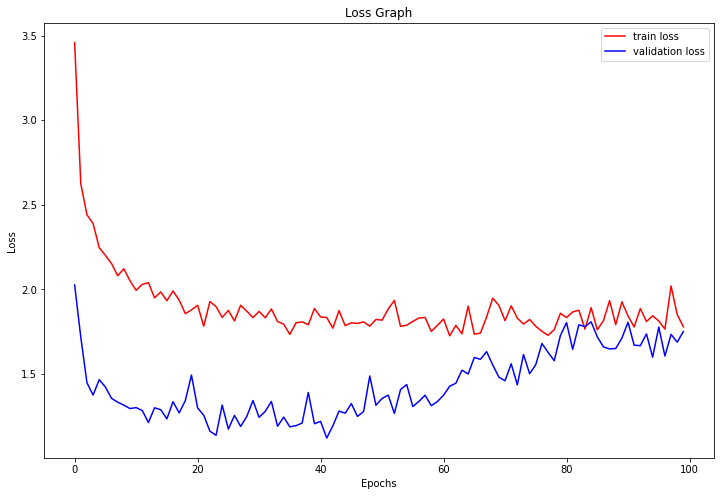

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

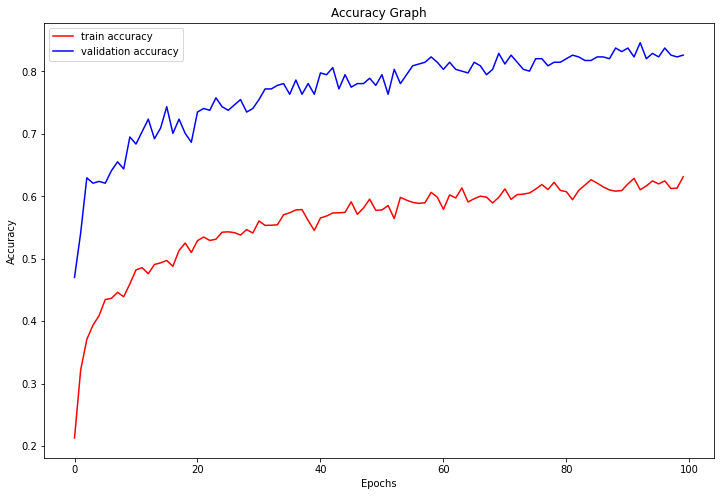

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'],'r',label='train accuracy')
plt.plot(history.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [ ]:
model.evaluate(test_images)

12/12 [==============================] - 21s 2s/step - loss: 1.7163 - accuracy: 0.8273


[1.716269850730896, 0.8272980451583862]